# Snapshot figure of ice bridge for main text of ms

In [1]:
## import required packages
import numpy as np
import pandas as pd
import sys
import xarray as xr
import matplotlib.pyplot as plt
import glob
import warnings
from pathlib import Path
import s3fs
from pprint import pprint
import matplotlib
from matplotlib.backends.backend_pdf import PdfPages
from tqdm import tqdm
import cmocean
import os
import string
import cmocean
import matplotlib.colors as colors
import matplotlib.cm as cm

In [2]:
from dask.distributed import Client

client = Client("tcp://127.0.0.1:35141")
client

<Client: 'tcp://127.0.0.1:35141' processes=8 threads=32, memory=123.95 GiB>

### Open 3D model fields

In [3]:
# initialize s3 filesystem
s3_options = dict(anon=False)

In [4]:
# function to open zarr store with a provided s3 bucket path
def open_zarr_store(s3_path, s3_options):
    # initalize s3 file system
    s3 = s3fs.S3FileSystem(**s3_options)

    # define location of zarr store and open
    store = s3fs.S3Map(root=s3_path, s3=s3, check=False)
    zarr_store = xr.open_zarr(store)
    
    return zarr_store

In [5]:
# open geometry file for HH field
HH_grid = xr.open_dataset("~/efs-mount-point/mzahn/sassie/HH/GRID/GRID_GEOMETRY_SASSIE_HH_V1R1_NATIVE_LLC1080.nc")

In [6]:
# open SALT zarr store - [psu]
SALT_zarr_day = open_zarr_store('s3://ecco-processed-data/SASSIE/N1/HH/ZARR/SALT_AVG_DAILY.ZARR/', s3_options)

# open THETA zarr store - [degC]
THETA_zarr_day = open_zarr_store('s3://ecco-processed-data/SASSIE/N1/HH/ZARR/THETA_AVG_DAILY.ZARR/', s3_options)

# open SIarea zarr store - [fraction of sea ice, 0 to 1]
SI_zarr_day = open_zarr_store('s3://ecco-processed-data/SASSIE/N1/HH/ZARR/SIarea_AVG_DAILY.ZARR/', s3_options)

# open HEFF zarr store
heff_da = open_zarr_store('s3://ecco-processed-data/SASSIE/N1/HH/ZARR/SIheff_AVG_DAILY.ZARR/', s3_options)

In [7]:
# remove 2021 since we only have January and a few days in Feb that year
salt_day = SALT_zarr_day.SALT.sel(time=slice("2014","2020")).where(HH_grid.mask_basin==1)
theta_day = THETA_zarr_day.THETA.sel(time=slice("2014","2020")).where(HH_grid.mask_basin==1)
ice_day = SI_zarr_day.SIarea.sel(time=slice("2014","2020")).where(HH_grid.mask_basin.isel(k=0)==1)*100 # convert to percentage

In [8]:
HH_grid_land = HH_grid.mask_basin.isel(k=0).where(HH_grid.mask_basin.isel(k=0)==0)

### Manual dates

In [9]:
ice_dates_plume = np.array(['2020-10-15T12', '2020-10-25T12', '2020-10-30T12'], dtype='datetime64[ns]')

In [10]:
ice_dates_plume

array(['2020-10-15T12:00:00.000000000', '2020-10-25T12:00:00.000000000',
       '2020-10-30T12:00:00.000000000'], dtype='datetime64[ns]')

### open datasets

In [11]:
# open OHC zarr stores
fwc_ds = xr.open_zarr('/home/jpluser/efs-mount-point/mzahn/sassie/HH/ZARR/FWC/FWC_Beaufort_final.ZARR')
fwc_da = fwc_ds.fwc

ohc_mld_ds = xr.open_zarr('/home/jpluser/efs-mount-point/mzahn/sassie/HH/ZARR/OHC/OHC_MLD_Beaufort_final.ZARR')
ohc_mld_da = ohc_mld_ds.ohc

ohc_pyc_ds = xr.open_zarr('/home/jpluser/efs-mount-point/mzahn/sassie/HH/ZARR/OHC/OHC_PYC_Beaufort_final.ZARR')
ohc_pyc_da = ohc_pyc_ds.ohc_pyc

mld_ds = xr.open_zarr('/home/jpluser/efs-mount-point/mzahn/sassie/HH/ZARR/MLD/MLD_Beaufort_final.ZARR')
mld_da = mld_ds.mld

In [12]:
# select just beaufort region and ice date for each year
fwc_icedays = fwc_da.sel(time=ice_dates_plume).sel(i=slice(510,750),j=slice(110,390))
ohc_mld_icedays = ohc_mld_da.sel(time=ice_dates_plume).sel(i=slice(510,750),j=slice(110,390))
ohc_pyc_icedays = ohc_pyc_da.sel(time=ice_dates_plume).sel(i=slice(510,750),j=slice(110,390))
mld_icedays = mld_da.sel(time=ice_dates_plume).sel(i=slice(510,750),j=slice(110,390))
sic_icedays = ice_day.sel(time=ice_dates_plume).isel(i=slice(510,750),j=slice(110,390))

In [13]:
# select only beaufort land and bathy
land_beaufort = HH_grid_land.isel(i=slice(510,750),j=slice(110,390))
bathy_beaufort = HH_grid.isel(i=slice(510,750),j=slice(110,390)).Depth

In [14]:
# Flip and reassign coordinates
def flip_and_attach_coords(da, reverse=False):
    flipped = np.rot90(da, 3, axes=(1, 2))  # rotate (lat, lon) to (i, j)
    new_da = xr.DataArray(flipped, dims=['time', 'i', 'j'])
    
    # Reassign time coordinate
    new_da = new_da.assign_coords(time=da.time)

    # Optional: negate values if needed (e.g., for MLD)
    if reverse:
        new_da *= -1

    return new_da.load()

fwc_flip = flip_and_attach_coords(fwc_icedays)
ohc_mld_flip = flip_and_attach_coords(ohc_mld_icedays/1e6)
ohc_pyc_flip = flip_and_attach_coords(ohc_pyc_icedays/1e6)
mld_flip = flip_and_attach_coords(mld_icedays, reverse=True)
sic_flip = flip_and_attach_coords(sic_icedays)

In [15]:
land_flip = np.rot90(land_beaufort, 3, axes=(0, 1))
land_flip = xr.DataArray(land_flip, dims=['i', 'j'])

bathy_flip = np.rot90(bathy_beaufort, 3, axes=(0, 1))
bathy_flip = xr.DataArray(bathy_flip, dims=['i', 'j'])

### Make a custom sea ice colormap

In [16]:
from matplotlib.colors import LinearSegmentedColormap

# Function to truncate colormap
def truncate_colormap(cmap, minval=0.2, maxval=1.0, n=100):
    new_cmap = LinearSegmentedColormap.from_list(
        f'trunc({cmap.name},{minval:.2f},{maxval:.2f})',
        cmap(np.linspace(minval, maxval, n))
    )
    return new_cmap

In [17]:
# truncate the cmocean ice colormap to avoid very dark colors
trunc_ice = truncate_colormap(cmocean.cm.ice, minval=0.2, maxval=1.0)

In [18]:
def remap_colormap(cmap, nonlin_scale=np.sqrt, n=256):
    """
    Remap a colormap so that lower values are compressed (darker colors take up less space),
    and higher values (lighter colors) are stretched out.
    
    Parameters:
    - cmap: The original colormap (e.g., cmocean.cm.ice)
    - nonlin_scale: A function that maps [0,1] -> [0,1] nonlinearly (default: np.sqrt)
    - n: Number of color levels
    
    Returns:
    - A new colormap with redistributed colors.
    """
    # Generate linearly spaced values, then apply non-linear scaling
    orig_vals = np.linspace(0, 1, n)
    remapped_vals = nonlin_scale(orig_vals)

    # Normalize remapped values to stay in [0,1]
    remapped_vals = (remapped_vals - remapped_vals.min()) / (remapped_vals.max() - remapped_vals.min())

    # Map those values through the original colormap
    new_colors = cmap(remapped_vals)
    
    return LinearSegmentedColormap.from_list(f'remapped_{cmap.name}', new_colors, N=n)

In [19]:
# create a nonlinearly adjusted colormap from the cmocean ice colormap
custom_cmap = remap_colormap(cmocean.cm.ice, nonlin_scale=np.sqrt)  # sqrt compresses low end

***

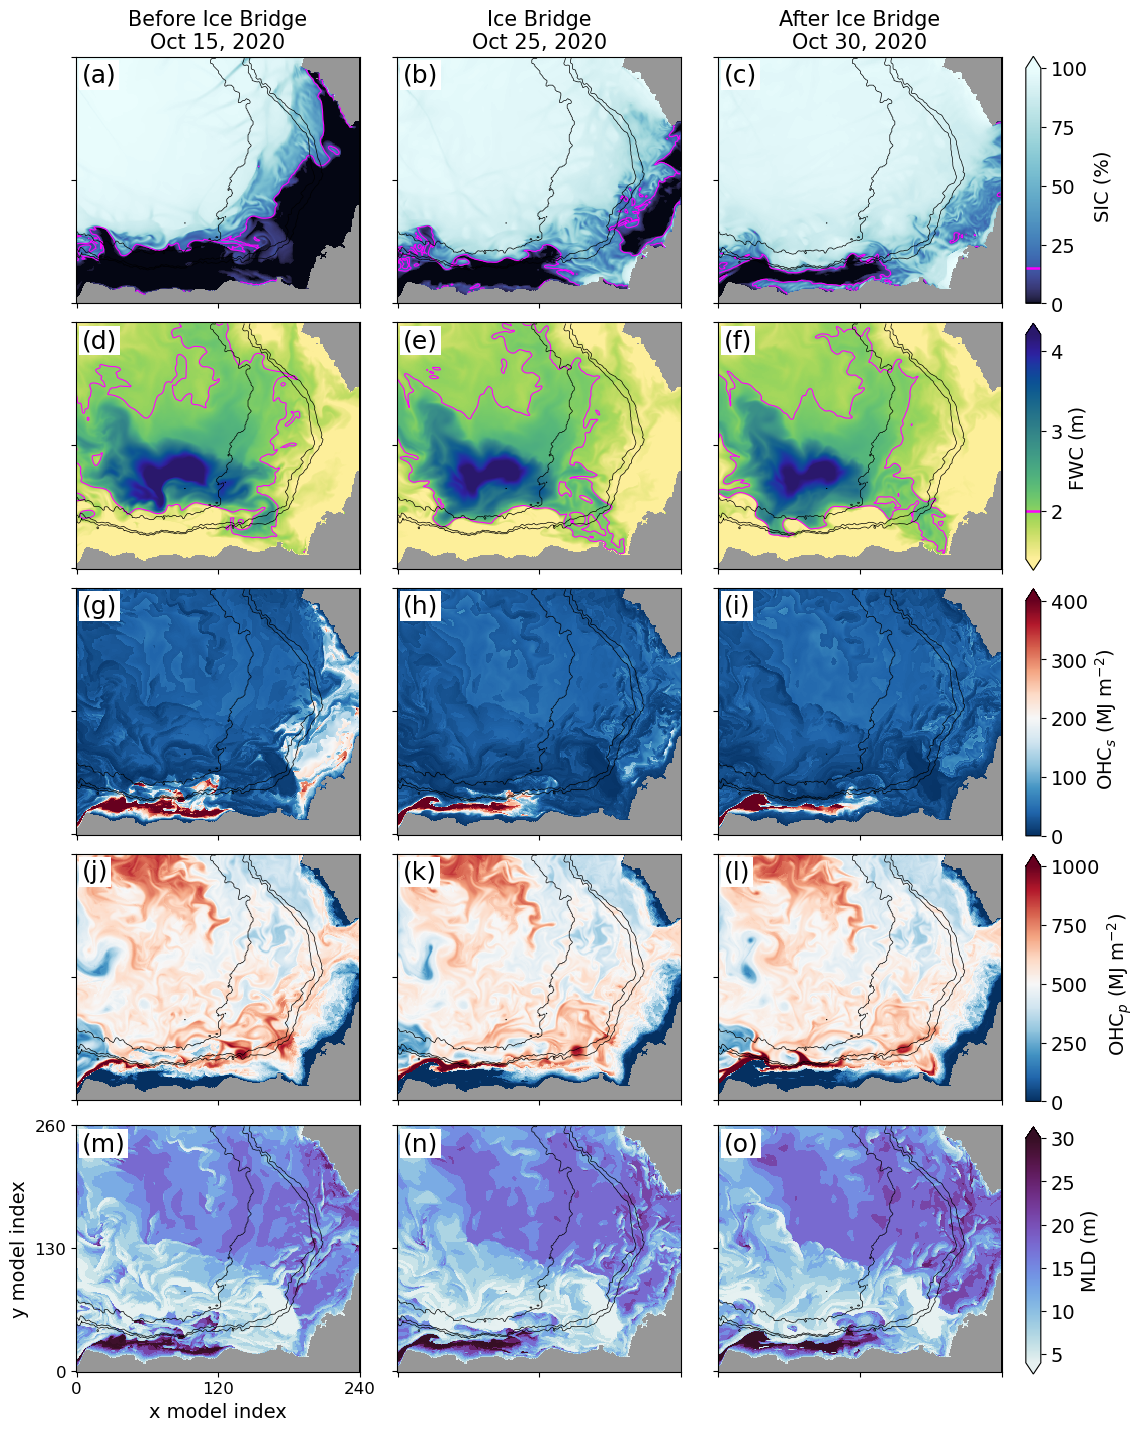

In [22]:
dates = ['2020-10-15', '2020-10-25', '2020-10-30']
# dates = ['2020-10-18', '2020-10-25', '2020-11-02']
nrows, ncols = 5, 3
fig, axes = plt.subplots(nrows, ncols, figsize=(10, 14.2), constrained_layout=True)
fig.set_constrained_layout_pads(hspace=0.05, wspace=0.05)
plt.rcParams.update({'font.size': 14})

# Variable settings for each row
variables = ['SIC', 'FWC', 'OHCs', 'OHCp', 'MLD']
cmaps = [custom_cmap, cmocean.cm.haline_r, 'RdBu_r', 'RdBu_r', cmocean.cm.dense]
vmins = [0, 1.4, 0, 0, 4]
vmaxs = [100, 4.2, 400, 1000, 30]

# Add subplot labels (a)–(l)
for i, ax in enumerate(axes.flatten()):
    label = f"({string.ascii_lowercase[i]})"
    ax.text(0.02, 0.975, label, transform=ax.transAxes, fontsize=18, \
            va='top', ha='left',bbox=dict(facecolor='white', edgecolor='none', pad=2))

# Main plotting loop
for col, date in enumerate(dates):
    for row in range(nrows):
        ax = axes[row, col]
        var = variables[row]

        # Choose appropriate dataset and plotting settings
        if var == 'SIC':
            da = sic_flip.sel(time=date).isel(time=0)
            sic_plot = da.plot(ax=ax, cmap=cmaps[row], vmin=vmins[row], vmax=vmaxs[row], add_colorbar=False)
            da.plot.contour(ax=ax, levels=[15], linewidths=0.8, colors='magenta', add_colorbar=False)
        elif var == 'FWC':
            da = fwc_flip.sel(time=date).isel(time=0)
            fwc_plot = da.plot(ax=ax, cmap=cmaps[row], vmin=vmins[row], vmax=vmaxs[row], add_colorbar=False)
            da.plot.contour(ax=ax, levels=[2], linewidths=0.8, colors='magenta', add_colorbar=False)
        elif var == 'OHCs':
            da = ohc_mld_flip.sel(time=date).isel(time=0)
            ohc_mld_plot = da.plot(ax=ax, cmap=cmaps[row], vmin=vmins[row], vmax=vmaxs[row], add_colorbar=False)
        elif var == 'OHCp':
            da = ohc_pyc_flip.sel(time=date).isel(time=0)
            ohc_pyc_plot = da.plot(ax=ax, cmap=cmaps[row], vmin=vmins[row], vmax=vmaxs[row], add_colorbar=False)
        elif var == 'MLD':
            da = mld_flip.sel(time=date).isel(time=0)
            mld_plot = da.plot(ax=ax, cmap=cmaps[row], vmin=vmins[row], vmax=vmaxs[row], add_colorbar=False)

        # Add background maps
        land_flip.plot(ax=ax, cmap='Greys_r', add_colorbar=False)
        bathy_flip.plot.contour(ax=ax, colors='k', linewidths=0.5, levels=[500,1000,3000])

        # Formatting
        ax.set_facecolor('k')
        ax.set_yticks([0,120,240])
        ax.set_xticks([0,140,280])
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_xlabel("")
        ax.set_ylabel("")

axes[-1, 0].set_xlabel('x model index',size=14)
axes[-1, 0].set_ylabel('y model index',size=14)
axes[-1, 0].set_xticklabels([0,120,240],size=12)
axes[-1, 0].set_yticklabels([0,130,260],size=12)
axes[-1, 1].set_xticklabels(["", "", "     "])

axes[0,0].set_title(f'Before Ice Bridge\nOct 15, 2020', size=15)
axes[0,1].set_title(f'Ice Bridge\nOct 25, 2020', size=15)
axes[0,2].set_title(f'After Ice Bridge\nOct 30, 2020', size=15)

# Colorbars
cbar_ax1 = fig.add_axes([1.02, 0.79, 0.015, 0.174]) # [left, bottom, width, height]
cbar1 = fig.colorbar(sic_plot, cax=cbar_ax1, extend='max')
cbar1.ax.axhline([15], color='magenta', linewidth=1.8)
cbar1.set_ticks([0, 25, 50, 75, 100])
cbar1.set_label("SIC (%)")

cbar_ax2 = fig.add_axes([1.02, 0.602, 0.015, 0.174])
cbar2 = fig.colorbar(fwc_plot, cax=cbar_ax2, extend='both')
cbar2.ax.axhline([2], color='magenta', linewidth=1.8)
cbar2.set_ticks([2, 3, 4])
cbar2.set_label("FWC (m)")

cbar_ax3 = fig.add_axes([1.02, 0.415, 0.015, 0.174])
cbar3 = fig.colorbar(ohc_mld_plot, cax=cbar_ax3, extend='max')
cbar3.set_ticks([0,100,200,300,400])
cbar3.set_label("OHC$_s$ (MJ m$^{-2}$)")

cbar_ax4 = fig.add_axes([1.02, 0.228, 0.015, 0.174])
cbar4 = fig.colorbar(ohc_pyc_plot, cax=cbar_ax4, extend='max')
cbar4.set_ticks([0,250,500,750,1000])
cbar4.set_label("OHC$_p$ (MJ m$^{-2}$)")

cbar_ax5 = fig.add_axes([1.02, 0.036, 0.015, 0.174])
cbar5 = fig.colorbar(mld_plot, cax=cbar_ax5, extend='both')
cbar5.set_ticks([5, 10, 15, 20, 25, 30])
cbar5.set_label("MLD (m)")

# save figure
plt.savefig("/home/jpluser/git_repos/SASSIE_ECCO_salinity_stratification/figures/fig2.png", dpi=300, bbox_inches='tight')

plt.show()